<a href="https://colab.research.google.com/github/ParasB-523/EIS_6th_Sem/blob/main/CIFAR_100_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
!pip install kaggle

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
!kaggle datasets download -d fedesoriano/cifar100

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/cifar100
License(s): copyright-authors
cifar100.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip -q cifar100.zip -d cifar100

In [8]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data_pre_path = '/content/cifar100//' # change this path
# File paths
data_train_path = data_pre_path + 'train'
data_test_path = data_pre_path + 'test'
data_meta_path = data_pre_path + 'meta'

# Read dictionary
data_train = unpickle(data_train_path)
data_test = unpickle(data_test_path)
data_meta = unpickle(data_meta_path)

subCategory = pd.DataFrame(data_meta['fine_label_names'], columns=['SubClass'])
subCategoryDict = subCategory.to_dict()

X_train = data_train['data']
y_train=data_train['fine_labels']

# Usaremos 20% de la data de entrenamiento para validar el desempeño de la red en cada epoch.
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8)

X_train = X_train.reshape(len(X_train),3,32,32).transpose(0,2,3,1)
X_valid = X_valid.reshape(len(X_valid),3,32,32).transpose(0,2,3,1)

#transforming the testing dataset
X_test = data_test['data']
X_test = X_test.reshape(len(X_test),3,32,32).transpose(0,2,3,1)
y_test = data_test['fine_labels']

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_valid = np.asarray(X_valid)
y_valid = np.asarray(y_valid)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)


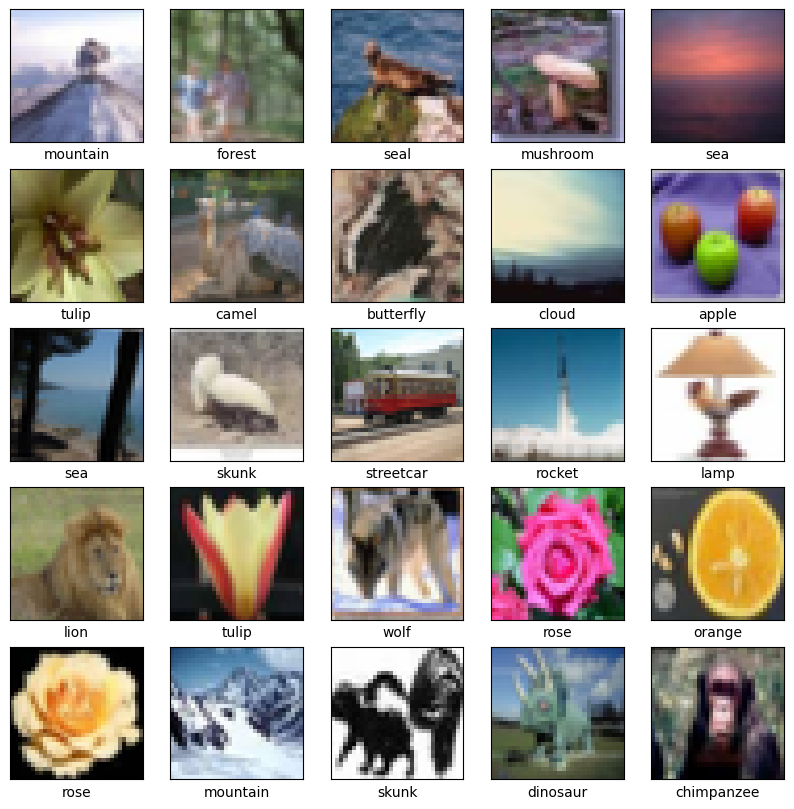

In [9]:
###############################################################################
# comprobar las labels de algunas imágenes
###############################################################################

plt.figure(figsize=(10,10))
for image in range(0,25):
    i=image
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    j=i+0# añadir de 25 en 25 para cambiar el bloque de fotos
    data_plot = X_test[j]
    plt.imshow(data_plot)
    plt.xlabel(str(subCategoryDict['SubClass'][y_test[j]]))
plt.show()

In [ ]:
##############################################################################
#plot history
##############################################################################

def plot_history(history):
    val_loss = history.history['val_loss' ]
    loss =     history.history['loss' ]
    acc =      history.history['accuracy' ]
    val_acc =  history.history['val_accuracy' ]

    epochs    = range(1,len(acc)+1,1)

    plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
    plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
    plt.title ('Training and validation accuracy')
    plt.ylabel('acc')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

    plt.plot  ( epochs,     loss, 'r--', label='Training loss' )
    plt.plot  ( epochs, val_loss ,  'b', label='Validation loss' )
    plt.title ('Training and validation loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()


In [ ]:
##############################################################################
#MODELO KERAS
##############################################################################
model = Sequential()
model.add(Conv2D(input_shape=(32, 32, 3), kernel_size=(2, 2), padding='same', strides=(2, 2), filters=32))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
model.add(Conv2D(kernel_size=(2, 2), padding='same', strides=(2, 2), filters=64))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(100, activation='softmax'))

model.summary()


opt = 'adam'

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 256)               1

In [ ]:
###############################################################################
#PREPROCESADO CON ImageDataGenerator
###############################################################################

augmenter = ImageDataGenerator(rescale=1.0/255.,
                             rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.2,
                             fill_mode='nearest',
                             horizontal_flip=True)
rescalator=ImageDataGenerator(rescale=1.0/255.)

train_generator=augmenter.flow(X_train, y_train, batch_size=20)
valid_generator=rescalator.flow(X_valid, y_valid, batch_size=20)
test_generator=rescalator.flow(X_test, y_test, batch_size=20)

In [ ]:
############################################################################
#ENTRENAMIENTO DEL MODELO
############################################################################
#EPOCHS=100
#EPOCHS=1
EPOCHS=30
batch_size=20
steps_per_epoch=train_generator.n//batch_size
validation_steps=valid_generator.n//batch_size
history = model.fit(train_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=EPOCHS,
                        validation_data=valid_generator,
                        validation_steps=validation_steps
                        )

Epoch 1/30
2000/2000 [==============================] - 45s 20ms/step - loss: 3.7377 - accuracy: 0.1256 - val_loss: 3.2348 - val_accuracy: 0.2062
Epoch 2/30
2000/2000 [==============================] - 34s 17ms/step - loss: 3.1712 - accuracy: 0.2235 - val_loss: 2.9088 - val_accuracy: 0.2737
Epoch 3/30
2000/2000 [==============================] - 35s 18ms/step - loss: 2.9390 - accuracy: 0.2674 - val_loss: 2.7660 - val_accuracy: 0.3050
Epoch 4/30
2000/2000 [==============================] - 35s 18ms/step - loss: 2.7997 - accuracy: 0.2951 - val_loss: 2.7441 - val_accuracy: 0.3226
Epoch 5/30
2000/2000 [==============================] - 36s 18ms/step - loss: 2.7053 - accuracy: 0.3143 - val_loss: 2.6695 - val_accuracy: 0.3246
Epoch 6/30
2000/2000 [==============================] - 35s 18ms/step - loss: 2.6375 - accuracy: 0.3282 - val_loss: 2.7265 - val_accuracy: 0.3254
Epoch 7/30
2000/2000 [==============================] - 33s 17ms/step - loss: 2.5624 - accuracy: 0.3430 - val_loss: 2.5532 -

500/500 - 1s - loss: 2.4511 - accuracy: 0.3972 - 1s/epoch - 3ms/step
test accuracy:  0.39719998836517334


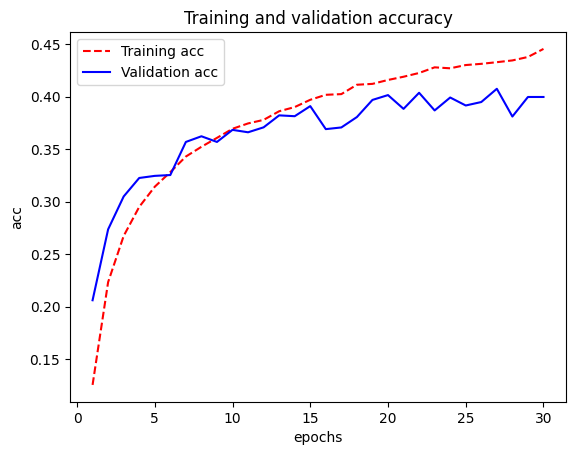

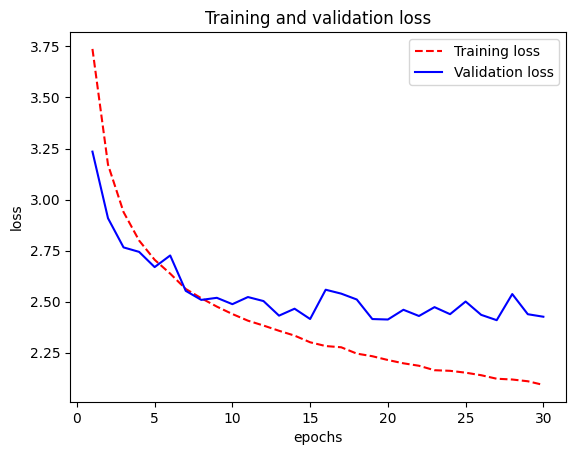

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_history(history)
test_loss,test_acc=model.evaluate(test_generator, verbose=2)
print("test accuracy: ",test_acc)

313/313 [==============================] - 1s 2ms/step


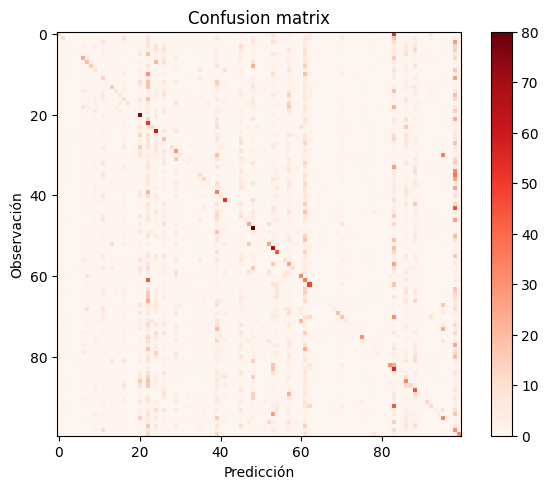

In [ ]:
###############################################################################
# confussion matrix
###############################################################################
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.tight_layout()
    plt.ylabel('Observación')
    plt.xlabel('Predicción')
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis = 1)
confusion_mtx = confusion_matrix(y_test, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(100))

In [ ]:
idx,counts =np.unique(Y_pred_classes,return_counts=True,axis=0)
np.unique(Y_pred_classes,return_counts=True,axis=0)

print('CLASSES CHOOSEN MANY TIMES')
for number in range(idx.shape[0]):
    clase=idx[number]
    if counts[number]>500:
        print('clase: ' +(str(subCategoryDict['SubClass'][clase]))+' ('+str(clase) +') counts: '+str(counts[number]))

CLASSES CHOOSEN MANY TIMES
clase: clock (22) counts: 815
clase: plate (61) counts: 661
clase: sweet_pepper (83) counts: 735
clase: woman (98) counts: 891


In [ ]:
print('CLASSES NOT CHOOSEN')
for all_classes in range(100):
    found=False
    for i in range(idx.shape[0]):
        if all_classes==idx[i]:
            found=True
    if found==False:
        print('clase: ' +(str(subCategoryDict['SubClass'][all_classes]))+' ('+str(all_classes) +') counts: '+str(0))

CLASSES NOT CHOOSEN
clase: bear (3) counts: 0
clase: beaver (4) counts: 0
clase: crocodile (27) counts: 0
clase: leopard (42) counts: 0
clase: lizard (44) counts: 0
clase: otter (55) counts: 0
clase: squirrel (80) counts: 0


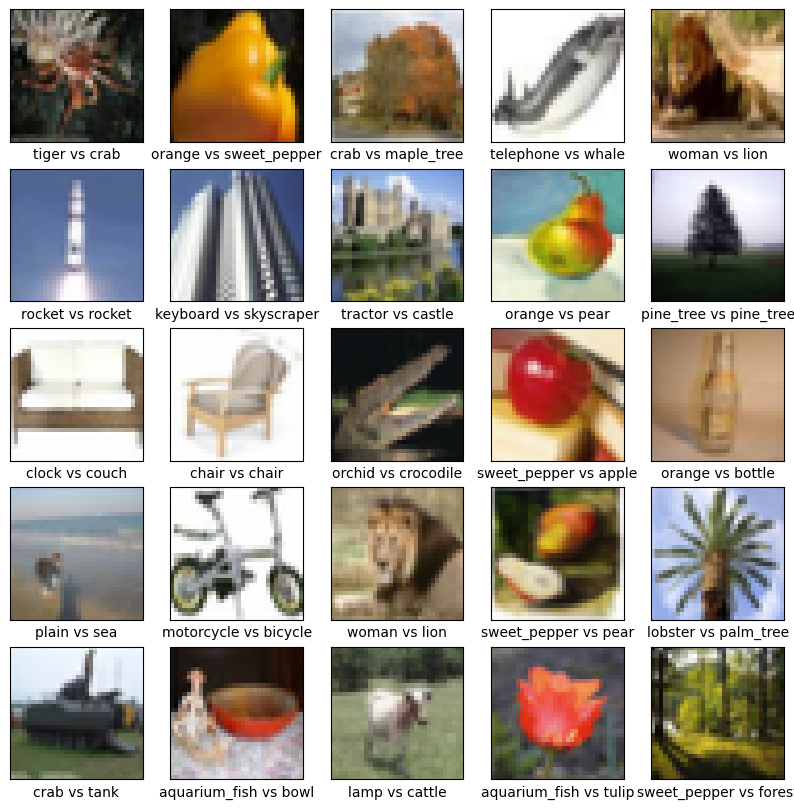

In [ ]:
###############################################################################
# algunas predicciones con imagen
###############################################################################
plt.figure(figsize=(10,10))
for image in range(0,25):
    i=image
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    j=i+100# añadir de 25 en 25 para cambiar el bloque de fotos
    data_plot = X_test[j]
    plt.imshow(data_plot)
    plt.xlabel(str(subCategoryDict['SubClass'][Y_pred_classes[j]]) + " vs " + str(subCategoryDict['SubClass'][y_test[j]]))
plt.show()

In [ ]:
# Save the model
model.save('/content/model_saved')